### Model-based anomaly detection.

#### Given a learned Bayes Net structure, the lowest-likelihood data records are considered most anomalous.

In [29]:
import pandas as pd
import numpy as np

data = pd.read_csv("NYC_taxi_sample.csv")

# make all columns small integer counts (0, 1, ..., cardinality-1)
data.loc[:,'tip':'pass'] -= 1

Step 1: Learn structure. 

In [30]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
# For other versions of pgmpy, move scoring_method parameter from initialization function to estimate function 
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('manhattan', 'speed'), ('manhattan', 'tip'), ('manhattan', 'pass'), ('manhattan', 'dist'), ('speed', 'dist'), ('pass', 'tip')]


Step 2: Learn parameters.

In [31]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianNetwork(best_model.edges())
model.fit(data, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of manhattan:
+--------------+----------+
| manhattan(0) | 0.514543 |
+--------------+----------+
| manhattan(1) | 0.485457 |
+--------------+----------+
CPD of speed:
+-----------+---------------------+---------------------+
| manhattan | manhattan(0)        | manhattan(1)        |
+-----------+---------------------+---------------------+
| speed(0)  | 0.12509117432531    | 0.30575956706609975 |
+-----------+---------------------+---------------------+
| speed(1)  | 0.22283005105762219 | 0.4136064940085041  |
+-----------+---------------------+---------------------+
| speed(2)  | 0.2024070021881838  | 0.16041747197526093 |
+-----------+---------------------+---------------------+
| speed(3)  | 0.1987600291757841  | 0.07073830691921144 |
+-----------+---------------------+---------------------+
| speed(4)  | 0.1301969365426696  | 0.03440278314650174 |
+-----------+---------------------+---------------------+
| speed(5)  | 0.12071480671043035 | 0.01507537688442211 |
+-----------+---

Step 3. Compute log-likelihood of each data record given the model, and report the lowest likelihood (most anomalous) records.

In [32]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        theparents_list = []
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
            theparents_list.append(parent)
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents_list,theprob)
        loglike += np.log(theprob)
    return loglike

In [33]:
# compute anomalousness of each of the first 500 data records
exmp=data.iloc[:500,:].apply(lambda x: LL(x,model),axis=1)

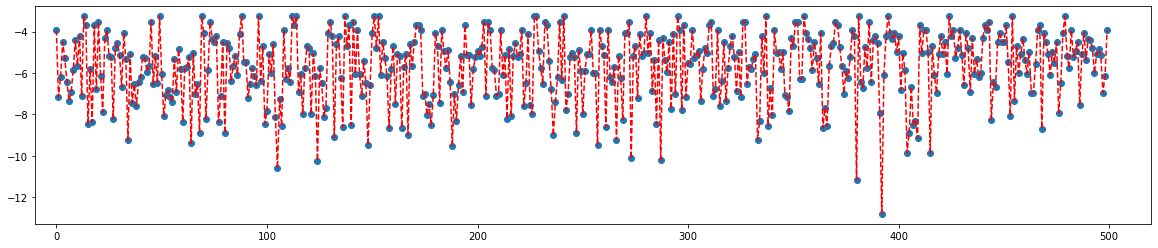

In [34]:
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(exmp)),exmp)
plt.xlim(-10,520)
plt.plot(exmp,"r--")
plt.show()

In [35]:
# 10 most anomalous data records
print(exmp.sort_values().head(10))

392   -12.801587
380   -11.166174
105   -10.608484
124   -10.224565
287   -10.220718
273   -10.125625
404    -9.853001
415    -9.853001
188    -9.506725
148    -9.492480
dtype: float64


In [36]:
# look at the most anomalous record
print(data.iloc[392,:])
print()
LL(data.iloc[392,:],model,verbose=True)

manhattan    1
tip          4
dist         1
speed        5
pass         1
Name: 392, dtype: int64

manhattan [] 0.48545693375867893
speed ['manhattan'] 0.015075376884422112
tip ['manhattan', 'pass'] 0.03696498054474708
pass ['manhattan'] 0.19868573637417858
dist ['manhattan', 'speed'] 0.05128205128205128


-12.801586904756427

In [37]:
# look at the second most anomalous record
print(data.iloc[380,:])
print()
LL(data.iloc[380,:],model,verbose=True)

manhattan    1
tip          0
dist         4
speed        4
pass         2
Name: 380, dtype: int64

manhattan [] 0.48545693375867893
speed ['manhattan'] 0.03440278314650175
tip ['manhattan', 'pass'] 0.06302521008403361
pass ['manhattan'] 0.09199845380749903
dist ['manhattan', 'speed'] 0.14606741573033707


-11.166173505919064

### Cluster-based anomaly detection

#### 1. Cluster with Gaussian Mixture.  Look for records with low log-likelihood as well as any tiny clusters.

In [38]:
# Simple example with Fisher's iris dataset
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:100]
y = iris.target[:100] # not used- unsupervised learning

In [39]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(X)

GaussianMixture(n_components=3, random_state=999)

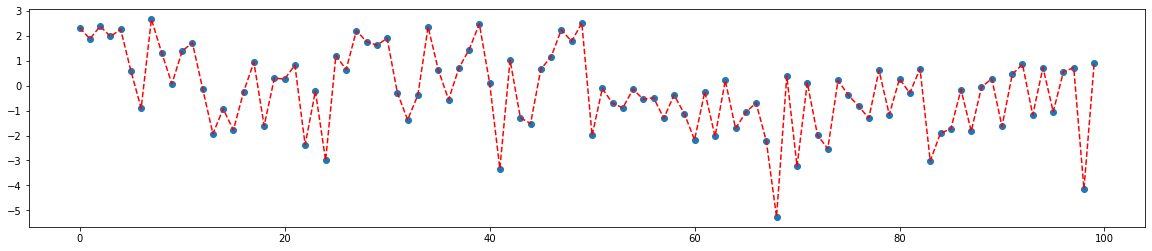

In [40]:
# score_samples function gives the log of the probability density of each data record given its cluster.
# Note that probability densities can exceed 1 (unlike probabilities of discrete data).
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X))
plt.plot(GM.score_samples(X),"r--")
plt.show()

In [41]:
# 5 most anomalous data points by log-likelihood (i.e. log probability density)
pd.DataFrame(GM.score_samples(X)).sort_values(0)[:5]

,0
68,-5.263206
98,-4.141623
41,-3.327299
70,-3.235414
83,-3.018343


In [15]:
# Also check for any very tiny clusters
print(pd.Series(GM.predict(X)).value_counts())

0    50
1    35
2    15
dtype: int64


#### 2. Cluster with k-means.  Look for records with large distance to the nearest cluster center as well as any tiny clusters.

In [42]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(X)

# distance to each cluster center
res=pd.DataFrame(KM.transform(X))
res.head()

,0,1,2
0,2.891832,0.141351,3.723625
1,2.820734,0.447638,3.753050
2,2.993133,0.417109,3.928577
3,2.832028,0.525338,3.800598
4,2.940369,0.188627,3.775299


In [43]:
# add cluster and distance information for each data record
res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
41,2.987345,1.248030,4.026315,1,1.248030
15,3.117260,1.204815,3.668385,1,1.204815
98,1.043109,1.991176,2.125923,0,1.043109
14,3.226274,1.014091,3.839212,1,1.014091
60,0.955349,2.600227,2.042763,0,0.955349


In [44]:
# check for tiny clusters
print(res['cluster'].value_counts())

1    50
0    26
2    24
Name: cluster, dtype: int64


## Practice Question

The data we will use here are the hourly bicycle counts on Seattle's Fremont Bridge. These data come from an automated bicycle counter, installed in late 2012, which has inductive sensors under the sidewalks on either side of the bridge.  Our goal is to detect days with abnormal counts.

In [45]:
import pandas as pd
data=pd.read_csv("Bridge.csv",index_col="Date",parse_dates=True)
data.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


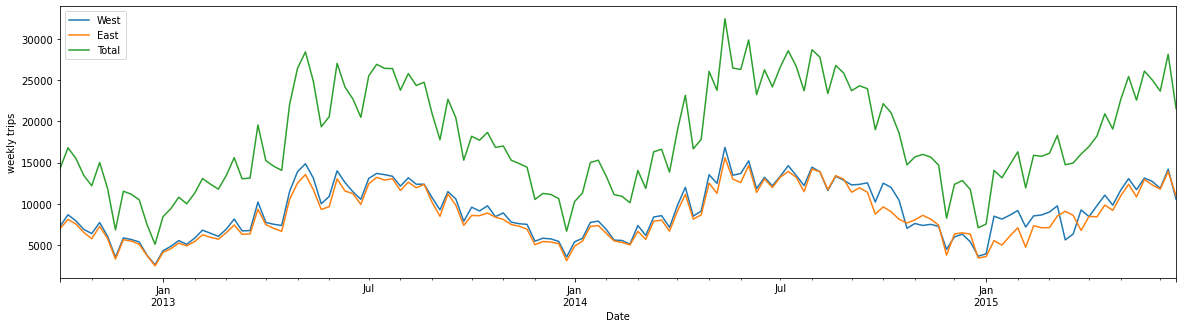

In [46]:
# visualizing the data
data.resample('W').sum().plot(figsize=(20,5))
plt.ylabel('weekly trips')
plt.show()

In [47]:
# counts for (West,East) for each hour of each day
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
days=pivoted.index
X=pivoted.values
print(pivoted.head())
print(X.shape)

           East                                       ... West                 \
Date         0  1  2    3  4   5   6    7    8    9   ...   14   15   16   17   
2012-10-03    9  6  1  3.0  1  10  50   95  146  104  ...   77   72  133  192   
2012-10-04   11  0  6  3.0  1  11  51   89  134   94  ...   63   73  114  154   
2012-10-05    7  4  3  2.0  2   7  37  101  119   81  ...   63   80  120  144   
2012-10-06    7  5  2  2.0  1   2  15   16   47   55  ...   89  115  107  107   
2012-10-07    5  5  1  2.0  2   3   8   12   26   36  ...  126  122  132  118   

                                     
Date         18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]
(990, 48)


#### Part 1. Detect abnormal days using Gaussian mixture clustering.

In [48]:
# Normalize the data so that the 48 columns for a given day sum to 1.  You can interpret each value as
# the proportion of that day's trips that are in a given direction (west or east) and in a given hour.
X = pivoted.values
X=X/X.sum(1).reshape(-1,1)
data2=pd.concat((pd.DataFrame(days),pd.DataFrame(X)),axis=1)
data2.columns=["date"]+list(data2.columns)[1:]
data2.head()

,date,0,1,2,3,4,5,6,7,8,...,38,39,40,41,42,43,44,45,46,47
0,2012-10-03,0.002556,0.001704,0.000284,0.000852,0.000284,0.002840,0.014201,0.026981,0.041465,...,0.021869,0.020449,0.037773,0.054530,0.034649,0.016757,0.008236,0.007100,0.006816,0.001420
1,2012-10-04,0.003165,0.000000,0.001727,0.000863,0.000288,0.003165,0.014676,0.025612,0.038561,...,0.018129,0.021007,0.032806,0.044317,0.039424,0.016403,0.007770,0.008921,0.007194,0.003165
2,2012-10-05,0.002224,0.001271,0.000953,0.000635,0.000635,0.002224,0.011753,0.032084,0.037802,...,0.020013,0.025413,0.038119,0.045743,0.033990,0.013342,0.008577,0.003494,0.003177,0.005083
3,2012-10-06,0.003490,0.002493,0.000997,0.000997,0.000499,0.000997,0.007478,0.007976,0.023430,...,0.044367,0.057328,0.053340,0.053340,0.020439,0.019940,0.012463,0.008973,0.006979,0.007478
4,2012-10-07,0.002334,0.002334,0.000467,0.000934,0.000934,0.001401,0.003735,0.005602,0.012138,...,0.058824,0.056956,0.061625,0.055089,0.031746,0.012138,0.008870,0.005602,0.004202,0.002334


#### Now cluster the data using 5 Gaussian mixture components, and identify the 5 most anomalous days.

In [49]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=5,random_state=999)
GM.fit(data2.iloc[:,1:])

GaussianMixture(n_components=5, random_state=999)

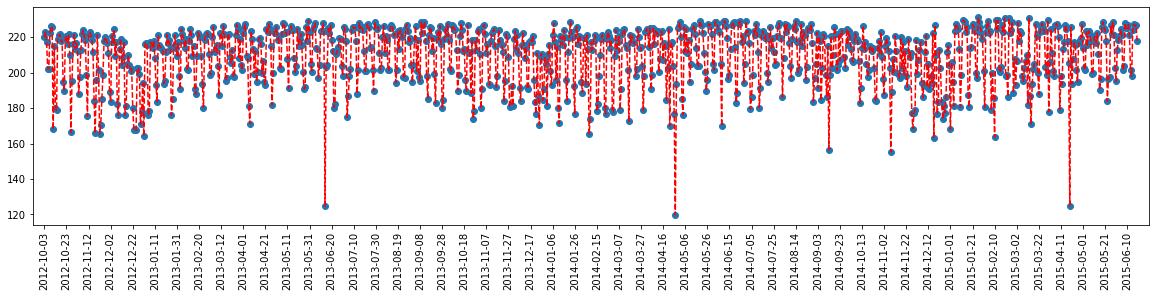

2014-04-27    119.903694
2013-06-14    124.695025
2015-04-19    124.824575
2014-11-08    155.283873
2014-09-13    156.404423
dtype: float64

1    516
0    219
3    118
2     86
4     51
dtype: int64


In [50]:
import matplotlib.pylab as plt
X=data2.iloc[:,1:]
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X))
plt.xlim(-10,1000)
plt.xticks(range(len(X))[::20],days[::20],rotation=90)
plt.plot(GM.score_samples(X),"r--")
plt.show()
print(pd.Series(GM.score_samples(X),index=days).sort_values().head())
print()

# also check for tiny clusters
print(pd.Series(GM.predict(X)).value_counts())

#### Part 2. Detect abnormal days using k-means clustering.

In [51]:
# Normalize the data so that the 48 columns for a given day sum to 1.  You can interpret each value as
# the proportion of that day's trips that are in a given direction (west or east) on a given hour.
X = pivoted.values
X=X/X.sum(1).reshape(-1,1)
data3=pd.concat((pd.DataFrame(days),pd.DataFrame(X)),axis=1)
data3.columns=["date"]+list(data3.columns)[1:]

#### Now cluster the data using k-means clustering with k=5, and identify the 5 most anomalous days.

In [52]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=5,random_state=999)
KM.fit(data3.iloc[:,1:])
res=pd.DataFrame(KM.transform(data3.iloc[:,1:]))
res=pd.concat((pd.DataFrame(days),res.min(1)),axis=1)
res.columns=["date","score"]
print(res.sort_values("score",ascending=False)[:5])
print()

# also check for tiny clusters
print(pd.Series(KM.predict(data3.iloc[:,1:])).value_counts())

           date     score
50   2012-11-22  0.110715
766  2014-11-08  0.110645
613  2014-06-08  0.105361
448  2013-12-25  0.105086
83   2012-12-25  0.104056

0    615
3    183
1    126
4     49
2     17
dtype: int64


#### Part 3.  Detect anomalous days using Bayesian networks.

In [53]:
# Let's reduce from 48 variables to 10: proportions for midnight-1am, 11am-noon, 3-4pm, 6-7pm, 9-10pm going in each direction
X = pivoted.values
X=X/X.sum(1).reshape(-1,1)
XX = XX=X[:,[0,11,15,18,21,24,35,39,42,45]]
data4=pd.concat((pd.DataFrame(days),pd.DataFrame(XX)),axis=1)
data4.columns=["date","W0","W11","W15","W18","W21","E0","E11","E15","E18","E21"]

# discretize each variable to four equal-frequency bins (quartiles)
for i in data4.iloc[:,1:]:
    data4[i] = pd.qcut(data4[i],q=4,labels=False)
print(data4.head())

         date  W0  W11  W15  W18  W21  E0  E11  E15  E18  E21
0  2012-10-03   2    0    2    2    2   0    0    1    1    1
1  2012-10-04   2    2    1    2    2   1    1    1    2    2
2  2012-10-05   1    2    2    1    2   1    1    2    1    0
3  2012-10-06   2    2    3    0    0   3    3    3    0    2
4  2012-10-07   1    3    3    0    3   2    3    3    1    0


In [54]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
data=data4.iloc[:,1:]
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())
model = BayesianNetwork(best_model.edges())
model.fit(data, estimator=MaximumLikelihoodEstimator)

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('W11', 'E11'), ('W18', 'W11'), ('W18', 'W0'), ('W18', 'E18'), ('W18', 'E0'), ('W21', 'E21'), ('E11', 'W21'), ('E15', 'W15'), ('E15', 'W18')]


In [55]:
exmp=data.apply(lambda x: LL(x,model),axis=1)

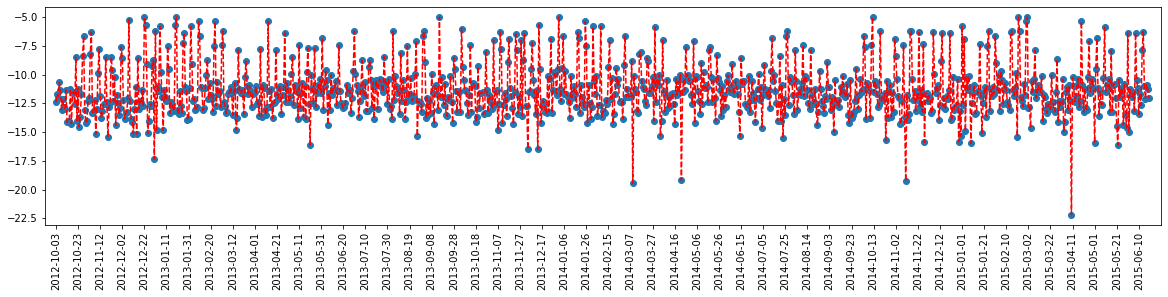

In [56]:
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(exmp)),exmp)
plt.plot(exmp,"r--")
plt.xlim(-10,1000)
plt.xticks(range(len(exmp))[::20],days[:1000][::20],rotation=90)
plt.show()

In [57]:
# 5 most anomalous data records
exmp2=pd.Series(exmp)
exmp2.index=days
print(exmp2.sort_values().head())

2015-04-10   -22.185014
2014-03-09   -19.469355
2014-11-11   -19.262759
2014-04-22   -19.198848
2012-12-31   -17.363295
dtype: float64


## Other anomaly detection methods in sklearn (time permitting)

### LOF

Local outlier factor (LOF).

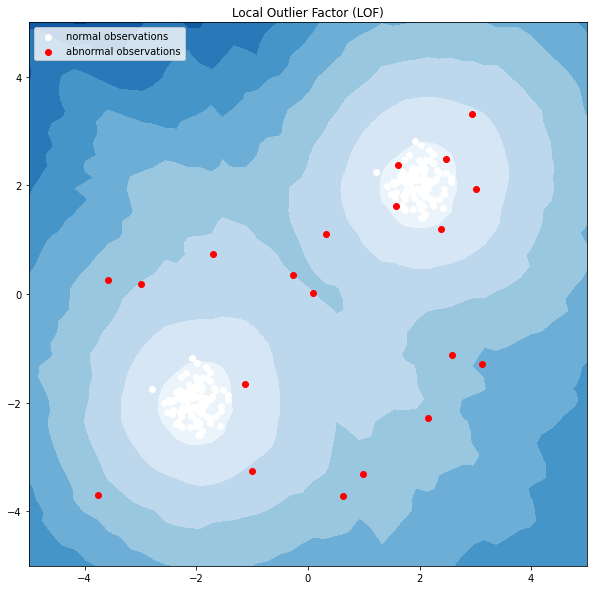

In [68]:
from sklearn.neighbors import LocalOutlierFactor

# Generate train data
np.random.seed(42)
X = 0.3 * np.random.randn(100, 2)
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X + 2, X - 2, X_outliers]

# fit the model
clf = LocalOutlierFactor(n_neighbors=20, novelty=True)
y_pred = clf.fit(X)._predict()
y_pred_outliers = y_pred[200:]

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))


plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='white')
b = plt.scatter(X[200:, 0], X[200:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

### One Class SVM and Isolation Forest

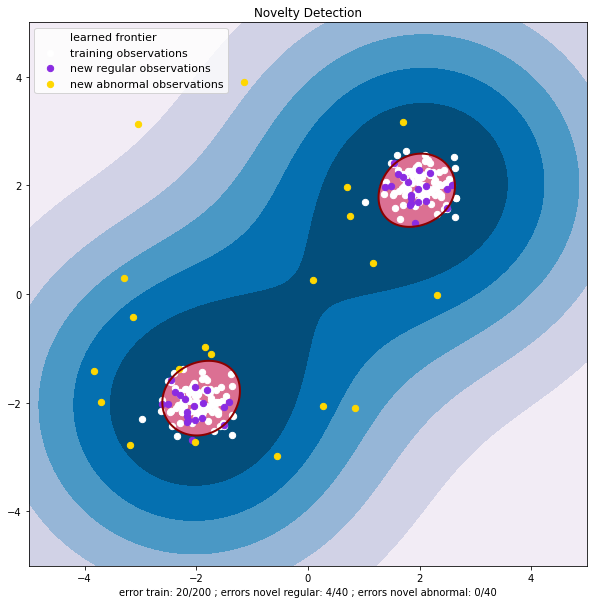

In [69]:
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

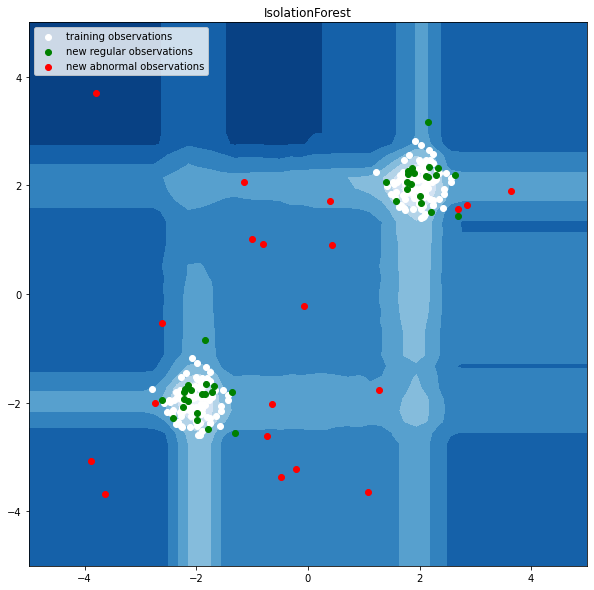

In [70]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

Sklearn makes a distinction between "novelty detection" with clean training data and "outlier detection" with training data possibly corrupted by a small proportion of anomalies.  This is _not_ standard usage-- anomaly, outlier, and novelty detection are generally used interchangeably in the literature, and it should be separately specified whether or not the training data is assumed to be clean.